# Introducción a la Ciencia de Datos: Tarea 2

Este notebook contiene el código de base para realizar la Tarea 2 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/).

**Se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.


## Cargar bibliotecas (dependencias)
Recuerde instalar los requerimientos (requirements.txt) en el mismo entorno donde está ejecutando este notebook (ver [README](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/)). Para la entrega 2 hay nuevas dependencias, por lo que es importante correr la siguiente celda.

In [1]:
#!pip install -r requirements.txt

In [2]:
import re
import os

from time import time
from pathlib import Path
from collections import Counter
import itertools
from itertools import chain
import unicodedata
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import nltk
import matplotlib.patches as mpatches


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

## Lectura de Datos

In [3]:
# DataFrame con todos los discursos:
df_speeches = pd.read_csv('./data/us_2020_election_speeches.csv')
df_speeches.head()

,speaker,title,text,date,location,type
0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,David Perdue: (00:01)\nHow great is it to be b...,"Oct 16, 2020","Macon, Georgia",Campaign Speech
1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Joe Biden: (00:00)\nHello, Michigan. Hi, how a...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech
2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,President Trump: (00:30)\nThank you. What a ni...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech
3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"George Stephanopoulos: (00:41)\nHey, and welco...","Oct 15, 2020",ABC,Town Hall
4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,Savannah Guthrie: (03:50)\nIt’s nothing but no...,"Oct 15, 2020",NBC,Town Hall


## Limpieza de Datos y

## Creación de un Dataframe con el texto de los top 3 candidatos sin encabezados

In [4]:
## Se reemplazan valores no informativos o ambiguos en la columna 'speaker', como "???" o "unknown", 
# por valores nulos ('NaN') para poder tratarlos correctamente en los análisis posteriores.

df_speeches["speaker"] = df_speeches["speaker"].replace(
    to_replace=r"^\?+$|^unknown$", value=pd.NA, regex=True
)

In [5]:
# vi) Verifico que los candidatos de Speaker aparecen en el Texto 
# a) Hallo los candidatos que aparecen como oradores en la columna texto


# ORADORES DE LA COLUMNA SPEAKER
# 1) Separar cada valor de 'speaker' por coma en columnas en un nuevo dataframe
DS_orador_from_speaker = df_speeches['speaker'].str.split(',', expand=True)

# 2) Normalizar: pasar a minúsculas y eliminar espacios al inicio
DS_orador_from_speaker = DS_orador_from_speaker.applymap(
    lambda x: x.lower().lstrip() if isinstance(x, str) else x
)
print("Orador_desde_Speaker")
print(DS_orador_from_speaker)

Orador_desde_Speaker
                         0     1     2
0             david perdue  None  None
1                joe biden  None  None
2             donald trump  None  None
3                joe biden  None  None
4             donald trump  None  None
..                     ...   ...   ...
264         bernie sanders  None  None
265  democratic candidates  None  None
266           donald trump  None  None
267           donald trump  None  None
268  democratic candidates  None  None

[269 rows x 3 columns]


C:\Users\karin\AppData\Local\Temp\ipykernel_26984\2762154006.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  DS_orador_from_speaker = DS_orador_from_speaker.applymap(


In [6]:
# ###  Definición de Funciones : EXTRAER ORADORES DE LA COLUMNA TEXT

# 1) extraer nombres después de un salto de línea y antes de ": (mm:ss)"
patron = re.compile(
    r'(?<=\n)'  # Asegura que el patrón esté precedido por un salto de línea
    r'([A-ZÁÉÍÓÚÑ][\wáéíóúñ]+(?:\s+[A-ZÁÉÍÓÚÑ][\wáéíóúñ]+)*)'  # Captura nombres propios
    r'(?=\s*:\s*\(\d{1,2}:\d{2}\))'  # Lookahead para ": (mm:ss)"
)

def extraer_oradores(texto):
    if not isinstance(texto, str):
        return []
    return patron.findall(texto)

# 2. Función para normalizar y eliminar duplicados manteniendo el orden
def normalize_and_dedup(names):
    seen = set()
    out = []
    for name in names:
        nm = name.lower().strip()
        if nm not in seen:
            seen.add(nm)
            out.append(nm)
    return out

In [7]:
# Extraer oradores de la columna texto y guardar en un nuevo dataframe: DS_orador_from_text

# 1) Extraer listas de oradores por fila
listas = df_speeches['text'].apply(extraer_oradores)

# 2) Normalizar y quitar duplicados
listas_clean = listas.apply(normalize_and_dedup)

# 3) Construir el DataFrame final: tantas filas como df_speeches, columnas según máximo hallado
DS_orador_from_text = pd.DataFrame(listas_clean.tolist(), index=df_speeches.index)

print("Orador_desde_Text")
print(DS_orador_from_text.head())

Orador_desde_Text
                 0                      1                2             3   \
0      david perdue                   None             None          None   
1         joe biden                   None             None          None   
2             crowd        president trump            seema  ron desantis   
3         joe biden  george stephanopoulos     nicholas fed     kelly lee   
4  savannah guthrie        president trump  jacqueline lugo  barbara peña   

               4           5                         6   \
0            None        None                      None   
1            None        None                      None   
2            None        None                      None   
3  anthony archer  voice over           cedric humphrey   
4   isabella peña    savannah  cristy montesinos alonso   

                      7                   8              9   ...    47    48  \
0                   None                None           None  ...  None  None   
1   

In [8]:
#   COMPARO ORADORES DE COLUMNA SPEAKER CON ORADORES DE COLUMNA TEXT Y REGISTRA DIFERENCIAS:

#  - DS_orador_from_speaker: DataFrame ancho con columnas 0,1,2… de oradores esperados
#  - DS_orador_from_text:    DataFrame ancho con columnas 0,1,2… de oradores extraídos

rows = []  # aquí acumularemos [fila, missing1, missing2, ...]

for idx in DS_orador_from_speaker.index:
    # 1) Lista de oradores esperados en esta fila (sin NaN, ya normalizados)
    expected = [v for v in DS_orador_from_speaker.loc[idx].tolist() if isinstance(v, str)]
    # 2) Lista de oradores detectados en el texto para esta misma fila
    detected = [v for v in DS_orador_from_text.loc[idx].tolist() if isinstance(v, str)]
    # 3) Identificar los que faltan
    missing = [s for s in expected if s not in detected]
    # 4) Si hay alguno faltante, lo agregamos junto con el índice
    if missing:
        rows.append([idx] + missing)

print(rows)
print(f"Hay {len(rows)} filas con diferencias entre los speakers de la columna 'speaker' y los extraídos de la columna 'text")

[[2, 'donald trump'], [4, 'donald trump'], [7, 'donald trump'], [10, 'donald trump'], [14, 'joe biden'], [16, 'mike pence'], [20, 'jaime harrison'], [22, 'donald trump'], [24, 'mike pence'], [25, 'donald trump'], [35, 'barack obama'], [39, 'mike pence'], [42, 'joe biden'], [46, 'donald trump', 'joe biden'], [62, 'donald trump'], [64, 'mike pence'], [65, 'donald trump'], [76, 'kamala harris'], [77, 'mike pence'], [82, 'donald trump'], [85, 'donald trump'], [87, 'donald trump'], [96, 'donald trump'], [100, 'joe biden'], [105, 'donald trump'], [106, 'multiple speakers'], [107, 'donald trump'], [113, 'kamala harris'], [114, 'multiple speakers'], [116, 'mike pence'], [124, 'multiple speakers'], [132, 'multiple speakers'], [136, 'donald trump jr.'], [140, 'multiple speakers'], [143, 'sarah cooper'], [157, 'jill biden'], [160, 'alexandria ocasio-cortez'], [168, 'gretchen whitmer'], [172, 'donald trump'], [173, 'mike pence'], [177, 'mike pence'], [183, 'kamala harris'], [184, 'joe biden', 'bar

In [9]:
# 5) Crear el DataFrame de discrepancias
#    La primera columna es 'row_index', las siguientes se nombran automáticamente 0,1,2…
DF_speaker_vs_text = pd.DataFrame(rows, columns=['row_index'] + 
                                  [f'missing_{i+1}' for i in range(max(len(r)-1 for r in rows))])

# En las filas indicadas a continuación, el orador de Speaker no se halla en el Texto correspondiente
print("Speaker_vs_Text")
print(DF_speaker_vs_text)

Speaker_vs_Text
    row_index                 missing_1     missing_2
0           2              donald trump          None
1           4              donald trump          None
2           7              donald trump          None
3          10              donald trump          None
4          14                 joe biden          None
5          16                mike pence          None
6          20            jaime harrison          None
7          22              donald trump          None
8          24                mike pence          None
9          25              donald trump          None
10         35              barack obama          None
11         39                mike pence          None
12         42                 joe biden          None
13         46              donald trump     joe biden
14         62              donald trump          None
15         64                mike pence          None
16         65              donald trump          None
17         7

In [10]:
# Crear DF_Oradores_Text_NoSpeaker tomando de DS_orador_from_text
DF_Oradores_Text_NoSpeaker = DS_orador_from_text.loc[
    DF_speaker_vs_text['row_index']
].copy()

# Insertar como primera columna el índice de fila de Speaker_vs_Text
DF_Oradores_Text_NoSpeaker.insert(
    0,
    'row_index',
    DF_speaker_vs_text['row_index'].values
)

print("Oradores que aparecen en Text y que no aparecen en Speaker")
print(DF_Oradores_Text_NoSpeaker)

Oradores que aparecen en Text y que no aparecen en Speaker
     row_index                           0                                1  \
2            2                       crowd                  president trump   
4            4            savannah guthrie                  president trump   
7            7                    audience                            crowd   
10          10             president trump                            crowd   
14          14    vice president joe biden                             None   
16          16   vice president mike pence                         audience   
20          20              lindsey graham                   jamie harrison   
22          22      president donald trump                     sean hannity   
24          24   vice president mike pence                         audience   
25          25                       maria                  president trump   
35          35                        None                             N

In [11]:
# Obtener la Lista ordenada de oradores que aparecen en la columna 'speaker'

# PARA TRABAJAR UNIFICANDO/NORMALIZANDO LOS NOMBRES QUE MÁS APARECEN 
# SE CUENTA DE MAYOR A MENOR LA CANTIDAD DE VECES QUE APARECE UN NOMBRE ES SPEAKER 

# 1) Para cada fila, tomar los valores no nulos y quedarnos con los únicos
unique_per_row = DS_orador_from_speaker.apply(
    lambda row: pd.Series(row.dropna().unique()).tolist(),
    axis=1
)

# 2) Aplanar todas esas listas y contar ocurrencias de cada orador
counter = Counter(chain.from_iterable(unique_per_row))

# 3) Crear el DataFrame ordenado con dos columnas: 'orador' y 'count'
Lista_ordenada_oradores_Speaker = (
    pd.DataFrame(counter.items(), columns=['orador', 'count'])
      .sort_values('count', ascending=False)
      .reset_index(drop=True)
)

# Resultado
print("Lista_ordenada_oradores_Speaker")
print(Lista_ordenada_oradores_Speaker)

Lista_ordenada_oradores_Speaker
                orador  count
0            joe biden     81
1         donald trump     54
2           mike pence     20
3       bernie sanders     17
4        kamala harris     16
..                 ...    ...
60           rand paul      1
61           tim scott      1
62  kimberly guilfoyle      1
63     herschel walker      1
64            o’rourke      1

[65 rows x 2 columns]


In [12]:
# Obtener la Lista ordenada de oradores que aparecen en la columna 'text'

# IDEM ANTERIOR CON ORADORES DESDE TEXT

# 1) Para cada fila de DS_orador_from_text, tomar los oradores no nulos y únicos
unique_per_row_text = DS_orador_from_text.apply(
    lambda row: pd.Series(row.dropna().unique()).tolist(),
    axis=1
)

# 2) Aplanar todas esas listas y contar ocurrencias de cada orador
counter_text = Counter(chain.from_iterable(unique_per_row_text))

# 3) Crear el DataFrame ordenado con dos columnas: 'orador' y 'count'
Lista_ordenada_oradores_Text = (
    pd.DataFrame(counter_text.items(), columns=['orador', 'count'])
      .sort_values('count', ascending=False)
      .reset_index(drop=True)
)

# Resultado
print("Lista_ordenada_oradores_Text")
print(Lista_ordenada_oradores_Text.to_string())

Lista_ordenada_oradores_Text
                              orador  count
0                          joe biden     92
1                       donald trump     43
2                              crowd     36
3                           audience     35
4                     bernie sanders     27
5                      kamala harris     17
6                         mike pence     13
7                   elizabeth warren     12
8                     pete buttigieg     11
9          vice president mike pence      8
10                     amy klobuchar      7
11                       andrew yang      6
12          vice president joe biden      5
13            president donald trump      5
14                    mike bloomberg      5
15                      barack obama      5
16                   president trump      5
17                    lindsey graham      4
18                       cory booker      4
19                           jessica      4
20                    michelle obama      3
21 

In [13]:
# Función extraer para text

# Definimos un patrón RegEx para extraer los nombres de oradores que aparecen en el texto, justo antes del formato “: (mm:ss)” (ej. Donald Trump: (01:25))
# extraer nombres después de un salto de línea y antes de ": (mm:ss)"
patron = re.compile(
    r'(?<=\n)'  # Asegura que el patrón esté precedido por un salto de línea
    r'([A-ZÁÉÍÓÚÑ][\wáéíóúñ]+(?:\s+[A-ZÁÉÍÓÚÑ][\wáéíóúñ]+)*)'  # Captura nombres propios
    r'(?=\s*:\s*\(\d{1,2}:\d{2}\))'  # Lookahead para ": (mm:ss)"
)

# Aplica el patrón y devuelve una lista con todos los nombres detectados en el texto (si es str).
def extraer_oradores(texto):
    return patron.findall(texto) if isinstance(texto, str) else []

In [14]:
# Aplicamos la función a la columna 'text' del DataFrame. Para cada fila, obtenemos una lista de oradores, y luego la convertimos a un DataFrame.
DS_orador_from_text = pd.DataFrame(
    df_speeches['text'].apply(extraer_oradores).tolist(),
    index=df_speeches.index
).applymap(lambda x: x.lower().strip() if isinstance(x, str) else x)

C:\Users\karin\AppData\Local\Temp\ipykernel_26984\2220392447.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ).applymap(lambda x: x.lower().strip() if isinstance(x, str) else x)


In [15]:
#### Generar listado completo de oradores para identificar los distintos nombres que hacen referencia a una misma persona,
# y luego incorporar esas reglas a la función normalize_names para su estandarización.

# Aplanar listas completas (sin filtro por cantidad)
oradores_text = list(chain.from_iterable(DS_orador_from_text.values.tolist()))
conteo_text = Counter([o for o in oradores_text if isinstance(o, str)])

oradores_speaker = list(chain.from_iterable(DS_orador_from_speaker.values.tolist()))
conteo_speaker = Counter([o for o in oradores_speaker if isinstance(o, str)])

# Unir ambos conteos
conteo_total = conteo_text + conteo_speaker  # suma de Counter

# Crear DataFrame ordenado por frecuencia
df_oradores_totales = (
    pd.DataFrame(conteo_total.items(), columns=["orador", "cantidad_discursos"])
    .sort_values(by="cantidad_discursos", ascending=False)
    .reset_index(drop=True)
)

In [16]:
# 1) Definimos normalize_names
# Función para unificar diferentes formas de nombrar a los oradores más frecuentes en los discursos, 
# facilitando el análisis de frecuencia (Ej. “President Trump”, “Trump”, y “Donald Trump” se cuenten como un único “donald trump”).

def normalize_names(text):
    if not isinstance(text, str):
        return text

    text = text.lower().strip()  # Pasar a minúsculas y limpiar espacios
    
    # Regla: Eliminar ruido
    if text.lower().strip() in {
        'crowd', 'audience', 'multiple speakers', 'democratic candidates',
        'intro', 'announcer', 'group', 'moderator', 'reporters',
        'audience members', 'commercial', 'voice over', 'male', 'female',
        'congregation', 'interviewer'
    }:
        return None

    # Biden
    text = re.sub(r'\bvice president joe biden\b', 'joe biden', text, flags=re.IGNORECASE)
    text = re.sub(r'\bvice president biden\b', 'joe biden', text, flags=re.IGNORECASE)
    text = re.sub(r'(?<!\bjoe\s)\bbiden\b', 'joe biden', text, flags=re.IGNORECASE)

    # Trump (orden correcto: primero las formas más específicas)
    text = re.sub(r'\bpresident\s+donald\s+j\.?\s*trump\b', 'donald trump', text, flags=re.IGNORECASE)
    text = re.sub(r'\bdonald\s+j\.?\s*trump\b', 'donald trump', text, flags=re.IGNORECASE)
    text = re.sub(r'\bpresident\s+donald\s+trump\b', 'donald trump', text, flags=re.IGNORECASE)
    text = re.sub(r'\bpresident\s+trump\b', 'donald trump', text, flags=re.IGNORECASE)
    text = re.sub(r'(?<!\bdonald\s)\btrump\b(?!\s+jr\b)', 'donald trump', text, flags=re.IGNORECASE)


    # Kamala Harris
    text = re.sub(r'\bsenator kamala harris\b', 'kamala harris', text, flags=re.IGNORECASE)

    # Mike Pence
    text = re.sub(r'\bvice president mike pence\b', 'mike pence', text, flags=re.IGNORECASE)

    # Amy Klobuchar
    text = re.sub(r'\bsenator amy klobuchar\b', 'amy klobuchar', text, flags=re.IGNORECASE)

    # Elizabeth Warren
    text = re.sub(r'\bsenator elizabeth warren\b', 'elizabeth warren', text, flags=re.IGNORECASE)
    text = re.sub(r'\bwarren\b', 'elizabeth warren', text, flags=re.IGNORECASE)

    # Barack Obama
    text = re.sub(r'\bpresident barack obama\b', 'barack obama', text, flags=re.IGNORECASE)

    # Bill Clinton
    text = re.sub(r'\bpresident bill clinton\b', 'bill clinton', text, flags=re.IGNORECASE)

    # Hillary Clinton
    text = re.sub(r'\bhilary clinton\b', 'hillary clinton', text, flags=re.IGNORECASE)

    return text

# 2) Crear DataFrames limpios
DS_orador_from_speaker_clean = DS_orador_from_speaker.copy()
DS_orador_from_text_clean    = DS_orador_from_text.copy()

# 3) Aplicar normalize_names


DS_orador_from_speaker_clean = DS_orador_from_speaker_clean.map(
    lambda x: normalize_names(x) if isinstance(x, str) else x,
    na_action='ignore'
)
DS_orador_from_text_clean = DS_orador_from_text_clean.map(
    lambda x: normalize_names(x) if isinstance(x, str) else x,
    na_action='ignore'
)

In [17]:
# 1) Aplicar Series.unique() a cada fila para quedarnos solo con los valores únicos
DS_orador_from_text_clean = DS_orador_from_text_clean.apply(
    lambda row: pd.Series(row.dropna().unique()),  # dropna() quita NaN antes de unique()
    axis=1
)

# 2) Renombrar las columnas resultantes de forma genérica
DS_orador_from_text_clean.columns = [f'orador_{i+1}' for i in range(DS_orador_from_text_clean.shape[1])]

# 3) Rellenar con NaN las celdas faltantes si quieres asegurar un DataFrame rectangular
DS_orador_from_text_clean = DS_orador_from_text_clean.reindex(
    columns=DS_orador_from_text_clean.columns, 
    fill_value=pd.NA
)

# Mostrar resultado
# print("DS_orador_from_speaker_clean:")
# print(DS_orador_from_speaker_clean.to_string(index=False))
# print("\nDS_orador_from_text_clean:")
# print(DS_orador_from_text_clean.to_string(index=False))

In [18]:
# BUSCO DISCREPANCIAS ENTRE MATRICES LIMPIAS 

# 1) Inicializar lista para registros de discrepancias
rows = []

# 2) Recorrer cada fila por índice
for idx in DS_orador_from_speaker_clean.index:
    # a) Oradores esperados en la fila idx (sin NaN, ya normalizados)
    expected = [
        v for v in DS_orador_from_speaker_clean.loc[idx].tolist()
        if isinstance(v, str) and v != ''
    ]
    # b) Oradores detectados en text_clean para la misma fila
    detected = [
        v for v in DS_orador_from_text_clean.loc[idx].tolist()
        if isinstance(v, str) and v != ''
    ]
    # c) Identificar cuáles esperados NO aparecen en detected
    missing = [s for s in expected if s not in detected]
    # d) Si hay faltantes, agregar un registro: [fila, missing1, missing2, ...]
    if missing:
        rows.append([idx] + missing)

# 3) Construir el DataFrame final con la nomenclatura “_clean”
#    La primera columna es 'row_index', las siguientes son missing_1, missing_2, …
max_missing = max((len(r) - 1 for r in rows), default=0)
DF_speaker_vs_text_clean = pd.DataFrame(
    rows,
    columns=['row_index'] + [f'missing_{i+1}' for i in range(max_missing)]
)

# 4) Mostrar el resultado
# print("DF_speaker_vs_text_clean")
# print(DF_speaker_vs_text_clean)


In [19]:
# RELLENO CELDAS que son iguales a “democratic candidates”, “republican candidates”, “multiple speakers”, “???”  o que sean celdas vacías 
# por las columnas correspondientes a dicha fila i de la data frame DF_orador_from_text
# Partimos de los DataFrames originales: DS_orador_from_speaker y DS_orador_from_text

# Definimos las “keywords” que deben disparar el reemplazo
keywords = {
    'democratic candidates',
    'republican candidates',
    'multiple speakers',
    '???',
    'none',    # en minúsculas, para coincidir con .lower()
    ''         # cadena vacía
}

rows = []
max_len = 0

# 1) Iteramos sobre cada fila de DS_orador_from_speaker_clean
for idx, row in DS_orador_from_speaker_clean.iterrows():
    # Convertir todos los valores de la fila a cadenas minúsculas
    cells = [str(v).lower().strip() if pd.notna(v) else '' for v in row.tolist()]
    
    # 2) Determinar si hay alguna keyword en la fila original
    if any(cell in keywords for cell in cells):
        # Tomar **toda** la fila de DS_orador_from_text_clean
        values = DS_orador_from_text_clean.loc[idx].dropna().tolist()
    else:
        # Tomar **toda** la fila de DS_orador_from_speaker_clean
        values = row.dropna().tolist()
    
    rows.append(values)
    max_len = max(max_len, len(values))

# 3) Rellenar con pd.NA para que todas las filas tengan longitud max_len
records = [r + [pd.NA] * (max_len - len(r)) for r in rows]

# 4) Construir el DataFrame final con el mismo índice
DF_speaker_mas_text = pd.DataFrame(
    records,
    index=DS_orador_from_speaker_clean.index
)

# 5) Asignar nombres genéricos de columna
DF_speaker_mas_text.columns = [f'col{i+1}' for i in range(max_len)]

# Mostrar resultado
print("DF_speaker_mas_text")
print(DF_speaker_mas_text.head().to_string())

DF_speaker_mas_text
               col1                   col2             col3          col4            col5             col6                      col7                col8           col9         col10          col11 col12 col13 col14 col15 col16 col17 col18 col19 col20 col21 col22 col23 col24 col25 col26 col27 col28 col29 col30 col31 col32 col33 col34 col35 col36 col37 col38 col39 col40 col41 col42 col43 col44 col45 col46 col47 col48 col49 col50 col51 col52 col53 col54 col55 col56 col57
0      david perdue                   <NA>             <NA>          <NA>            <NA>             <NA>                      <NA>                <NA>           <NA>          <NA>           <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>
1         joe biden               

In [20]:
#CON LOS VALORES SANEDOS Y COMPLETOS, SUMO

#1) Eliminar duplicados por fila:
#    Para cada fila, quedarnos sólo con los valores únicos
DF_speaker_mas_text_nodup = DF_speaker_mas_text.apply(
    lambda row: pd.Series(row.dropna().unique()), axis=1
)

# 2) Contar frecuencia total sin repetir orador en la misma fila
counter = Counter()
def update_counter(row):
    # filtrar NaN y actualizar Counter con los valores de esta fila
    vals = [v for v in row if pd.notna(v)]
    counter.update(vals)

DF_speaker_mas_text_nodup.apply(update_counter, axis=1)

# 3) Crear DF_speaker_tot ordenado de mayor a menor
DF_speaker_tot = (
    pd.DataFrame(counter.items(), columns=['speaker', 'count'])
      .sort_values('count', ascending=False)
      .reset_index(drop=True)
)

# LISTA CON ORADORES DE MAYOR OCURRENCIA A MENOR OCURRENCIA Y CANTIDAD DE DISCURSOS EN LOS QUE APARECEN
print("DF_speaker_tot")
print(DF_speaker_tot.to_string())

DF_speaker_tot
                               speaker  count
0                            joe biden     97
1                         donald trump     53
2                       bernie sanders     27
3                           mike pence     21
4                        kamala harris     20
5           elizabeth elizabeth warren     12
6                       pete buttigieg     11
7                        amy klobuchar     10
8                          andrew yang      6
9                         barack obama      5
10                      mike bloomberg      5
11                     hillary clinton      4
12                         cory booker      4
13                      lindsey graham      4
14                             jessica      4
15                          tom steyer      3
16                        nancy pelosi      3
17                      jill joe biden      3
18                      michelle obama      3
19                          ben carson      2
20           govern

In [21]:
# # ------>  FINALMENTE los 5 candidatos/as con mayor cantidad de discursos.

top_5_candidatos = DF_speaker_tot.head(5).reset_index(drop=True)

print("top_5_candidatos")
print(top_5_candidatos)

top_5_candidatos
          speaker  count
0       joe biden     97
1    donald trump     53
2  bernie sanders     27
3      mike pence     21
4   kamala harris     20


In [22]:
# TODO: Visualización de los discursos de cada candidato a lo largo del tiempo 

# 1) Crear DataFrame Top_5 a partir de DF_speaker_tot
Top_5 = pd.DataFrame({
    'top_5': DF_speaker_tot['speaker'].head(5)
}).reset_index(drop=True)

# Ahora Top_5 tiene una columna 'Top_5' y cinco filas, con los nombres de los 3 candidatos.

# 2) Para cada uno de esos cinco candidatos, construir un DF_fecha_candidatoN
#    que capture las filas de DF_speaker_mas_text donde aparece el candidato,
#    junto con la fecha correspondiente de df_speeches.

for i, candidato in enumerate(Top_5['top_5'], start=1):
    # Filtrar filas donde ANY column in DF_speaker_mas_text coincida con el nombre del candidato
    mask = DF_speaker_mas_text.apply(lambda row: row.eq(candidato).any(), axis=1)
    
    # Crear DataFrame para este candidato
    df_fecha = pd.DataFrame({
        'candidato': DF_speaker_mas_text.index[mask].map(lambda idx: candidato),
        'date': df_speeches.loc[DF_speaker_mas_text.index[mask], 'date']
    }).reset_index(drop=True)
    
    # Asignar a variable dinámica DF_fecha_candidato{i}
    globals()[f'DF_fecha_candidato{i}'] = df_fecha

    # Mostrar 
    # print(f"DF_fecha_candidato{i} para {candidato}:")
    # print(df_fecha.head(), '\n')

In [23]:
# Crear nueva columna con todos los oradores únicos por fila
oradores = DF_speaker_mas_text.copy()

# Generar columna con lista de strings únicos
oradores["oradores_finales"] = oradores.apply(
    lambda row: list({v for v in row if isinstance(v, str)}),
    axis=1
)

# Extraer solo la columna final, con el índice correcto
col_oradores_finales = oradores["oradores_finales"]

# Agregar resultado de oradores finales (oradores extraídos de speaker y de text))
df_speeches["oradores_finales"] = col_oradores_finales

# Visualizar
# df_speeches.head(10)

In [24]:
# Crear una nueva columna 'text1' con el texto normalizado (minusculas y nombres estandarizados o none)
df_speeches['text1'] = df_speeches['text'].apply(normalize_names)

# Visualizar
# df_speeches.head(10)

In [25]:
# Extrae el texto correspondiente a cada orador en una columna, para cada uno de los top 5 oradores.

def extraer_intervenciones_por_orador(texto, oradores_normalizados):
    
    # Si el contenido no es un string (por ejemplo, NaN), devolver diccionario con textos vacíos
    if not isinstance(texto, str):
        return {orador: "" for orador in oradores_normalizados}

    # Compilar patrón regex que detecta encabezados de intervenciones en el formato:
    # salto de línea + Nombre Apellido: (mm:ss) o (hh:mm:ss)
    # inicio de línea  + Nombre Apellido: (mm:ss) o (hh:mm:ss)
    patron = re.compile(r'(?:^|\n)([A-Za-z \.]+): \(\d{2}:\d{2}(?::\d{2})?\)', flags=re.MULTILINE)

    bloques = [] # Lista donde se guardarán tuplas (orador_normalizado, segmento de texto)
    matches = list(patron.finditer(texto)) # Buscar todos los encabezados que matcheen el patrón
 
    # Iterar sobre todos los encabezados encontrados
    for i in range(len(matches)):
        nombre_crudo = matches[i].group(1).strip().lower() # Extraer nombre crudo del encabezado
        nombre_crudo = normalize_names(nombre_crudo)  # Normalizar nombre (según reglas definidas)

        # Definir el segmento del texto que corresponde a esa intervención
        inicio = matches[i].start()
        fin = matches[i + 1].start() if i + 1 < len(matches) else len(texto)
        segmento = texto[inicio:fin].strip()

        bloques.append((nombre_crudo, segmento)) # Guardar orador y su fragmento de texto

    # Crear diccionario con oradores como claves y texto acumulado como valor inicial vacío
    resultado = {orador: "" for orador in oradores_normalizados}
    
    # Completar el diccionario sólo con los oradores indicados (top 3)
    for orador, fragmento in bloques:
        if orador in resultado:
            resultado[orador] += fragmento + "\n" # Acumular texto correspondiente al orador

    return resultado

# Obtener lista de los 5 oradores principales desde Top_5_candidatos
top_5_oradores = top_5_candidatos['speaker'].tolist()

# Aplicar función de extracción a cada fila del DataFrame y expandir resultados como columnas nuevas
df_speeches[top_5_oradores] = df_speeches['text1'].apply(
    lambda t: pd.Series(extraer_intervenciones_por_orador(t, top_5_oradores))
)

# df_speeches.to_excel("df_speeches_con_texto_por_orador.xlsx", index=False)

# Visualizar
#df_speeches

In [26]:
# Crear un DataFrame con los discursos de los 5 candidatos más frecuentes
nombres_Top_5 = top_5_candidatos['speaker'].tolist()

# Filtrar filas donde al menos uno de los nombres del top 5 aparece en la columna "oradores_finales"
df_speeches_Top_5 = df_speeches[
    df_speeches["oradores_finales"].apply(lambda lista: any(orador in nombres_Top_5 for orador in lista))
].copy()

# Revisar el shape
print(df_speeches.shape)
print(df_speeches_Top_5.shape)

(269, 13)
(194, 13)


In [27]:
##  Toma como entrada las columnas con los discursos de los top 5 oradores, y reemplaz el nombre del orador : (MM:SS) por ' // '

def limpiar_encabezados(texto):
    """
    Reemplaza encabezados de orador (Ej. 'trump: (00:30)') por ' // '.
    
    """
    # Si el valor no es texto (por ejemplo, es NaN o None), lo deja sin cambios
    if not isinstance(texto, str):
        return texto
    
    # Busca patrones como "nombre apellido: (00:30)" o "(00:30:45)" y los reemplaza por " // "
    texto = re.sub(r'[A-Za-z \.]+: \(\d{2}:\d{2}(?::\d{2})?\)', 
                   ' // '           # texto por el que se reemplaza
                   , texto)

    return texto

# Aplica la función a las columnas de los top 5 oradores
for orador in top_5_oradores:
    df_speeches[orador] = df_speeches[orador].apply(limpiar_encabezados)

df_speeches_sin_encabezados = df_speeches.copy()

In [28]:
# Creación de clean_text acorde a mis necesidades

def clean_text(df, column_name):
    """
    Normaliza texto eliminando encabezados, puntuación, tildes y convirtiendo a minúsculas.
    Esto permite un conteo de palabras consistente.
    """
    result = df[column_name]

    # 1. Eliminar cualquier encabezado hasta el primer salto de línea
    # Justificación: Muchas transcripciones comienzan con metadatos irrelevantes como "TRUMP: (00:30)"
    result = result.str.replace(r"^[^\n]*\n", "", regex=True)

    # 2. Convertir todo a minúsculas
    # Justificación: Para que "You", "you", "YOU" se cuenten como la misma palabra
    result = result.str.lower()

    # 3. Eliminar acentos (tildes) y caracteres diacríticos
    # Justificación: Para unificar palabras como “señor” y “senor”
    result = result.apply(lambda x: unicodedata.normalize("NFKD", x).encode("ASCII", "ignore").decode("utf-8") if isinstance(x, str) else x)

    # 4. Reemplazar signos de puntuación por espacios
    # Justificación: Para evitar que "you.", "you,", "you!" se cuenten como palabras distintas
    # Se incluye un conjunto extendido de puntuación: comillas, guiones largos, etc.
    signos_extra = '“”‘’–—'
    tabla = str.maketrans(string.punctuation + signos_extra, ' ' * (len(string.punctuation) + len(signos_extra)))
    result = result.str.translate(tabla)

    # 5. Reemplazar múltiples espacios por uno solo y eliminar espacios laterales
    # Justificación: Limpieza final para evitar errores en tokenización
    result = result.str.replace(r'\s+', ' ', regex=True).str.strip()

    return result

In [29]:
df_speeches_sin_encabezados.head(2)

,speaker,title,text,date,location,type,oradores_finales,text1,joe biden,donald trump,bernie sanders,mike pence,kamala harris
0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,David Perdue: (00:01)\nHow great is it to be b...,"Oct 16, 2020","Macon, Georgia",Campaign Speech,[david perdue],david perdue: (00:01)\nhow great is it to be b...,,,,,
1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Joe Biden: (00:00)\nHello, Michigan. Hi, how a...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech,[joe biden],"joe biden: (00:00)\nhello, michigan. hi, how a...","// \nhello, michigan. hi, how are you? what’s...",,,,


Hasta Acá salió todo de la Tarea1

## Preparar Dataframe para clasificar discursos

In [30]:
# Paso 1: seleccionar columnas
df_reducido = df_speeches_sin_encabezados[['text1', 'joe biden', 'donald trump', 'bernie sanders']].copy()

# Paso 2: melt
df_melted = df_reducido.melt(
    id_vars='text1',
    value_vars=['joe biden', 'donald trump', 'bernie sanders'],
    var_name='target',
    value_name='text_orador'
)

# Paso 3: eliminar vacíos/nulos
df_melted = df_melted[df_melted['text_orador'].notna() & (df_melted['text_orador'].str.strip() != '')].reset_index(drop=True)

# Paso 4: aplicar limpieza
df_melted['clean_text'] = clean_text(df_melted, 'text_orador')

In [31]:
df_melted['target'].value_counts()

target
joe biden         101
donald trump       60
bernie sanders     27
Name: count, dtype: int64

In [32]:
## Verificamos

# Función auxiliar: cuenta celdas con texto no vacío
def contar_textos_no_vacios(df, columnas):
    return sum((df[col].str.strip() != '').sum() for col in columnas)

# Columnas que nos interesan
columnas_oradores = ['joe biden', 'donald trump', 'bernie sanders']

# Conteo real de celdas con texto en el DataFrame original
conteo_original = contar_textos_no_vacios(df_speeches_sin_encabezados, columnas_oradores)

# Conteo de filas en el nuevo DataFrame ya "derretido"
conteo_melted = len(df_melted)

print(f"Cantidad de celdas con texto en columnas originales: {conteo_original}")
print(f"Cantidad de filas en el nuevo DataFrame: {conteo_melted}")

if conteo_original == conteo_melted:
    print("✅ Coinciden: no se perdió información.")
else:
    print("⚠️ No coinciden: hay pérdida o exceso de datos.")


Cantidad de celdas con texto en columnas originales: 188
Cantidad de filas en el nuevo DataFrame: 188
✅ Coinciden: no se perdió información.


In [33]:
# Crear un Dataframe que solo contiene las columnas para Clasificación
df_clf = df_melted[['clean_text', 'target']]

In [34]:
df_clf.shape

(188, 2)

In [35]:
df_clf.isna().sum()

clean_text    0
target        0
dtype: int64

In [36]:
df_clf.head(2)

,clean_text,target
0,hello michigan hi how are you whats your name ...,joe biden
1,good to be with you okay i know it well well f...,joe biden


## Parte 1: Dataset y representación numérica de texto

In [37]:
# 1: Separar 30% del conjunto para test. Al resto lo llamamos "dev" (desarrollo).

# Variables originales
X = df_clf['clean_text']
y = df_clf['target']

# División estratificada para mantener proporciones por clase
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Mostrar tamaños de los conjuntos
print(f"Tamaños de los conjuntos: dev = {X_dev.shape}, test = {X_test.shape}")
print(f"Tamaños de los conjuntos: dev = {y_dev.shape}, test = {y_test.shape}")

Tamaños de los conjuntos: dev = (131,), test = (57,)
Tamaños de los conjuntos: dev = (131,), test = (57,)


In [38]:
# 2: Visualización de la proporción de cada candidato por conjunto

# Conteo de discursos por orador en cada conjunto
print("Distribución en el conjunto de desarrollo (dev):")
print(y_dev.value_counts())

print("\nDistribución en el conjunto de test:")
print(y_test.value_counts())


Distribución en el conjunto de desarrollo (dev):
target
joe biden         70
donald trump      42
bernie sanders    19
Name: count, dtype: int64

Distribución en el conjunto de test:
target
joe biden         31
donald trump      18
bernie sanders     8
Name: count, dtype: int64


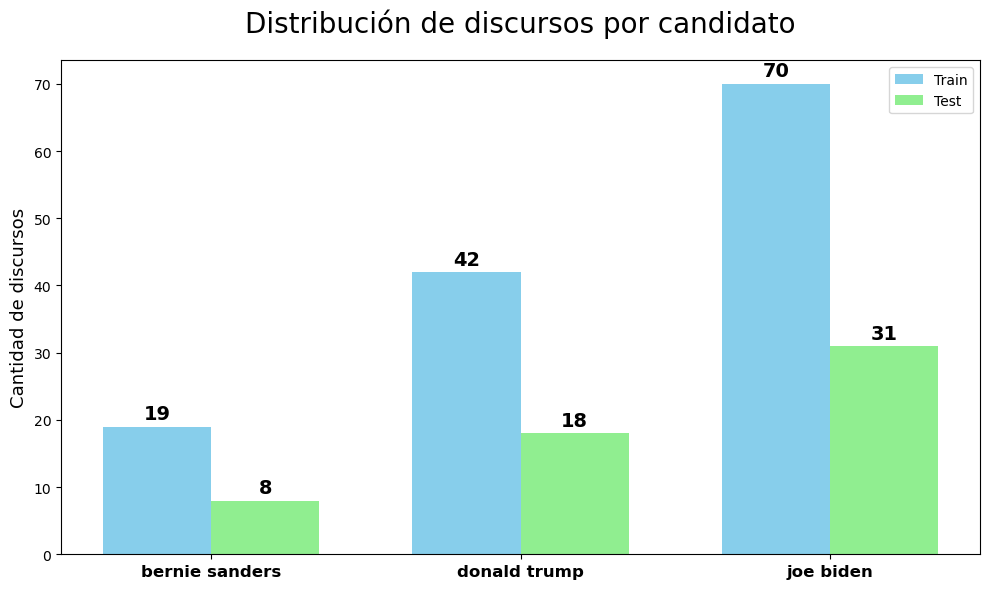

In [39]:
# Conteo por clase
conteo_train = y_dev.value_counts().sort_index()
conteo_test = y_test.value_counts().sort_index()

# Asegurar orden consistente de candidatos
candidatos = sorted(set(conteo_train.index) | set(conteo_test.index))
conteo_train = conteo_train.reindex(candidatos, fill_value=0)
conteo_test = conteo_test.reindex(candidatos, fill_value=0)

# Posiciones
x = np.arange(len(candidatos))
width = 0.35

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, conteo_train, width, label='Train', color='skyblue')
bars2 = ax.bar(x + width/2, conteo_test, width, label='Test', color='lightgreen')

# Ejes
ax.set_ylabel('Cantidad de discursos', fontsize=13)
ax.set_title('Distribución de discursos por candidato', fontsize=20, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(candidatos, fontsize=12, fontweight='bold', rotation=0)
ax.legend()

# Etiquetas sobre las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [40]:
# 3: Transforme el texto del conjunto de entrenamiento a la representación numérica (features) de conteo de palabras o bag of words.

# Crear el vectorizador y ajustarlo al conjunto de desarrollo
count_vect = CountVectorizer()

# Aplicar fit_transform para construir el vocabulario y transformar el texto
X_dev_counts = count_vect.fit_transform(X_dev)

# Mostrar forma de la matriz resultante
print("Shape de la matriz de conteo (Bag of Words):", X_dev_counts.shape)

Shape de la matriz de conteo (Bag of Words): (131, 13068)


In [41]:
X_dev_counts

<131x13068 sparse matrix of type '<class 'numpy.int64'>'
	with 129227 stored elements in Compressed Sparse Row format>

In [42]:
# 4: Obtenga la representación numérica Term Frequency - Inverse Document Frequency.

# Crear el transformador TF-IDF
tfidf_transformer = TfidfTransformer()

# Ajustar al conjunto de desarrollo y transformar
X_dev_tfidf = tfidf_transformer.fit_transform(X_dev_counts)

# Mostrar la shape de la matriz resultante
print("Shape de la matriz TF-IDF:", X_dev_tfidf.shape)


Shape de la matriz TF-IDF: (131, 13068)


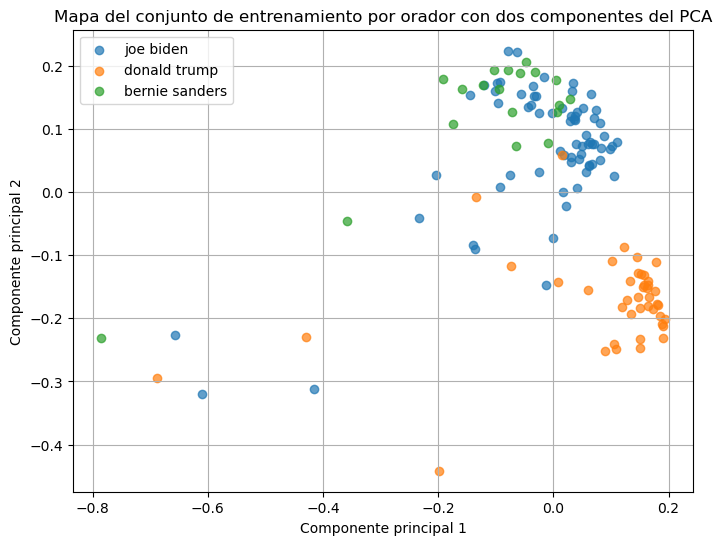

In [43]:
# 5 :Muestre en un mapa el conjunto de entrenamiento, utilizando las dos primeras componentes PCA sobre los vectores de tf-idf.

# Convertimos la matriz dispersa a array denso
X_dense = X_dev_tfidf.toarray()

# Aplicamos PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

# Graficamos en 2D con colores por orador
plt.figure(figsize=(8, 6))

for label in y_dev.unique():
    idx = y_dev == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.7)

plt.title("Mapa del conjunto de entrenamiento por orador con dos componentes del PCA")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend()
plt.grid(True)
plt.show()

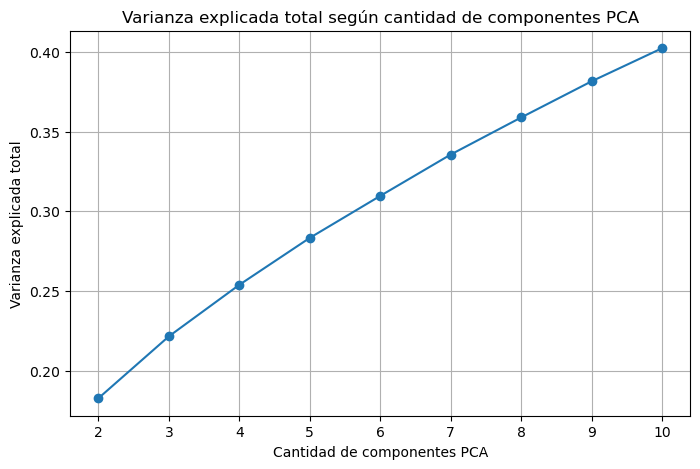

In [44]:
# Haga una visualización que permita entender cómo varía la varianza explicada a medida que se agregan componentes (e.g: hasta 10 componentes).

# Guardamos la varianza explicada acumulada para cada cantidad de componentes
varianzas = []

for n in range(2, 11):  # De 2 a 10 componentes
    pca = PCA(n_components=n)
    pca.fit(X_dense)
    var_exp = np.sum(pca.explained_variance_ratio_)
    varianzas.append(var_exp)

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), varianzas, marker='o')
plt.xticks(range(2, 11))
plt.xlabel('Cantidad de componentes PCA')
plt.ylabel('Varianza explicada total')
plt.title('Varianza explicada total según cantidad de componentes PCA')
plt.grid(True)
plt.show()

## Análisis Extra

In [45]:
# Cantidad máxima de componentes a utilizar (Cantidad de componentes no puede superar la cantidad de muestras)
n_samples, n_features = X_dense.shape
max_componentes = min(n_samples, n_features)
print(f"Podés usar como máximo {max_componentes} componentes.")

Podés usar como máximo 131 componentes.


In [46]:
# Encontrar el número mínimo de componentes que explican al menos el 99% de la varianza
for i, var_exp in enumerate(varianzas, start=2):  # empieza en 2 porque empezamos el for desde n=2
    if var_exp >= 0.99:
        print(f"Se necesitan al menos {i} componentes para explicar el 99% de la varianza.")
        break

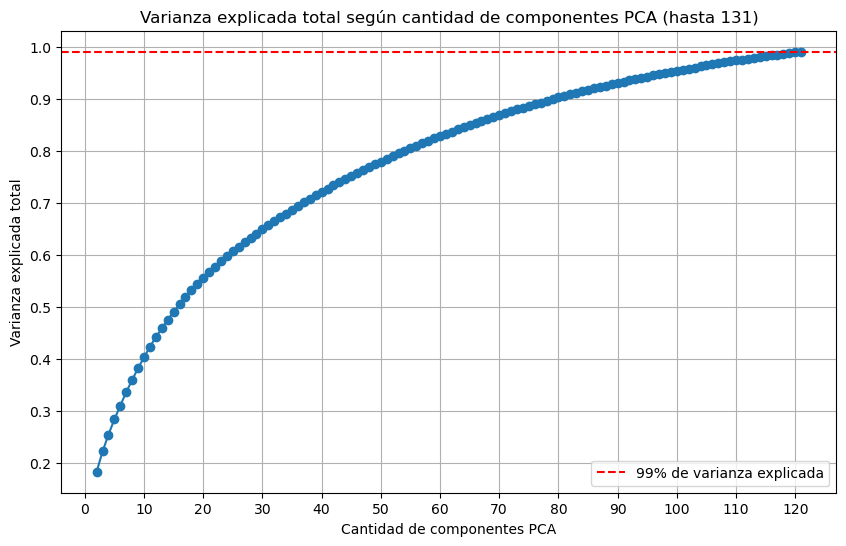

In [47]:
## Hacer el mismo gráfico con más componentes para entender cuantas necesitamos para explicar el 99% de la varianza

# Guardamos la varianza explicada acumulada
varianzas = []

for n in range(2, 122):  # De 2 a 121 componentes
    pca = PCA(n_components=n)
    pca.fit(X_dense)
    var_exp = np.sum(pca.explained_variance_ratio_)
    varianzas.append(var_exp)

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(2, 122), varianzas, marker='o')
plt.axhline(0.99, color='red', linestyle='--', label='99% de varianza explicada')
plt.xticks(range(0, 122, 10))
plt.xlabel('Cantidad de componentes PCA')
plt.ylabel('Varianza explicada total')
plt.title('Varianza explicada total según cantidad de componentes PCA (hasta 131)')
plt.legend()
plt.grid(True)
plt.show()

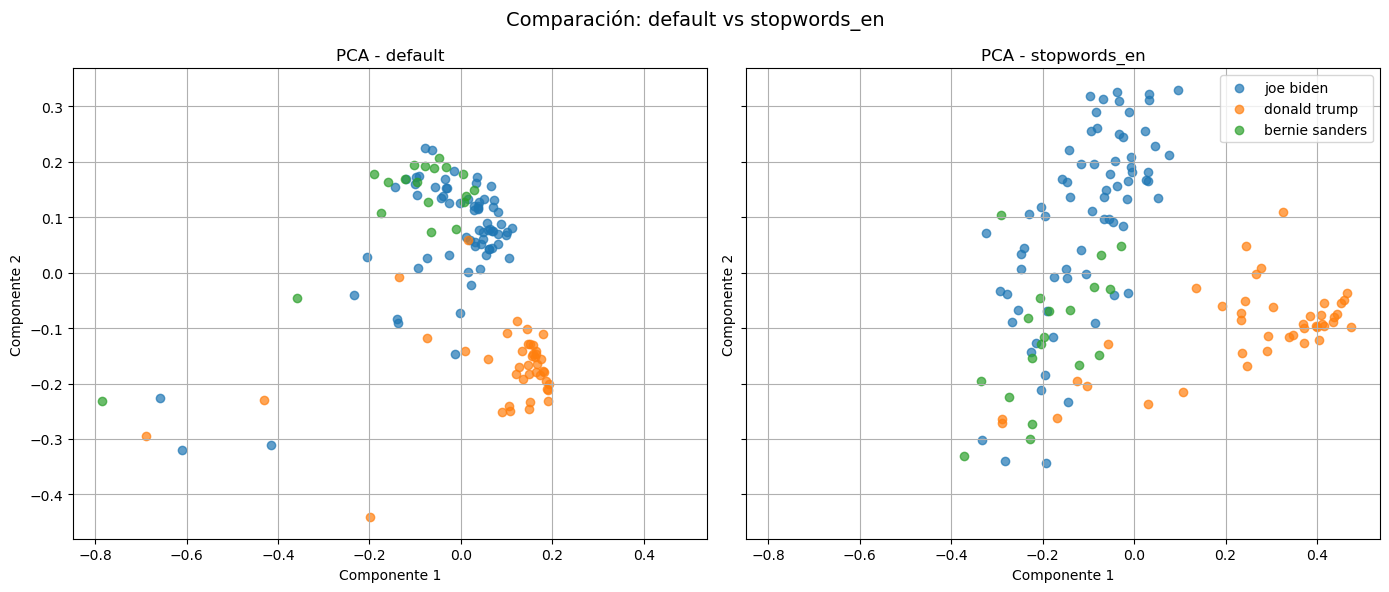

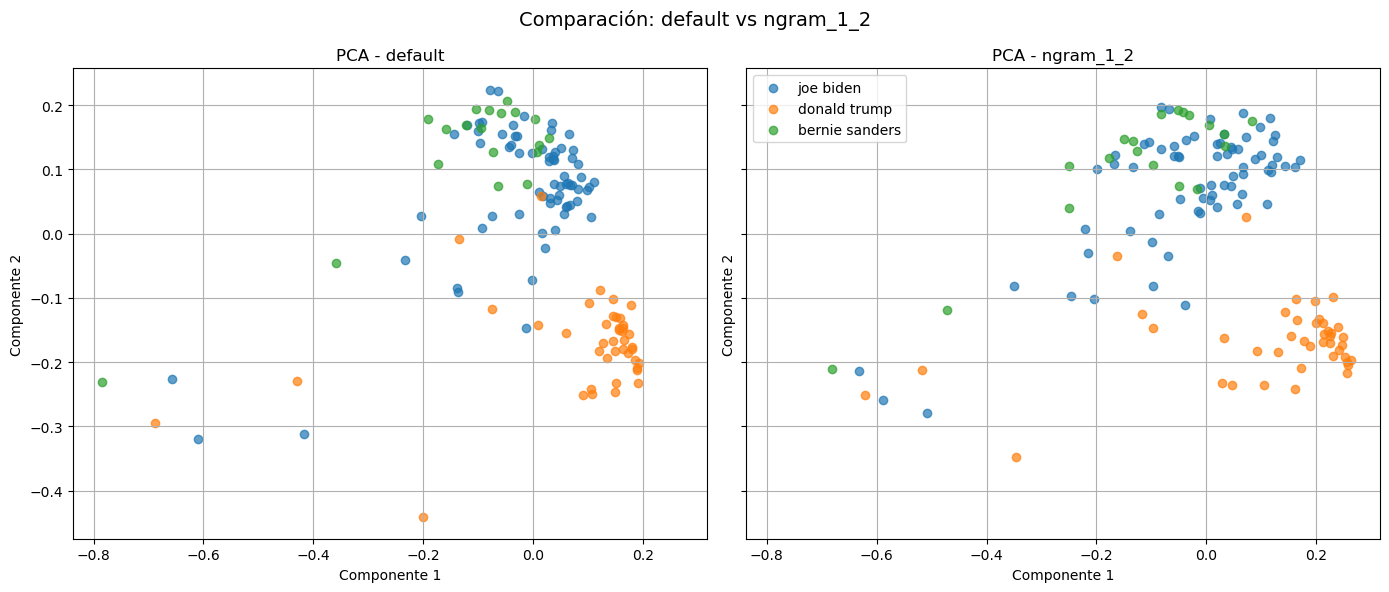

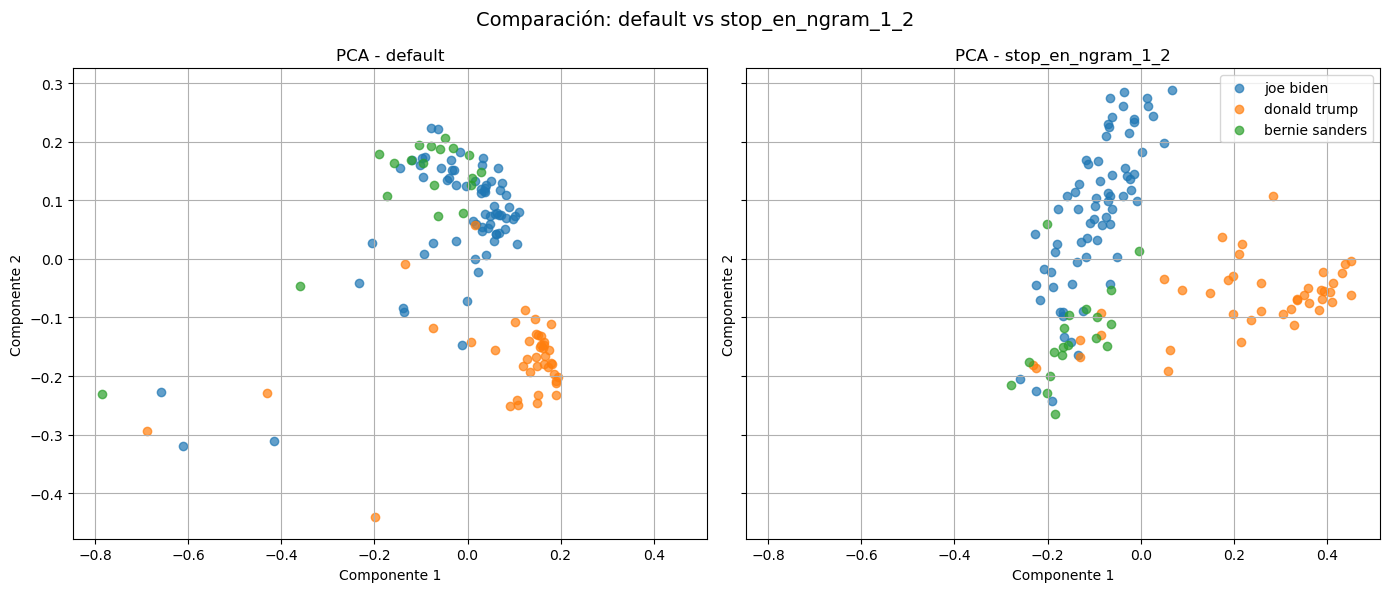

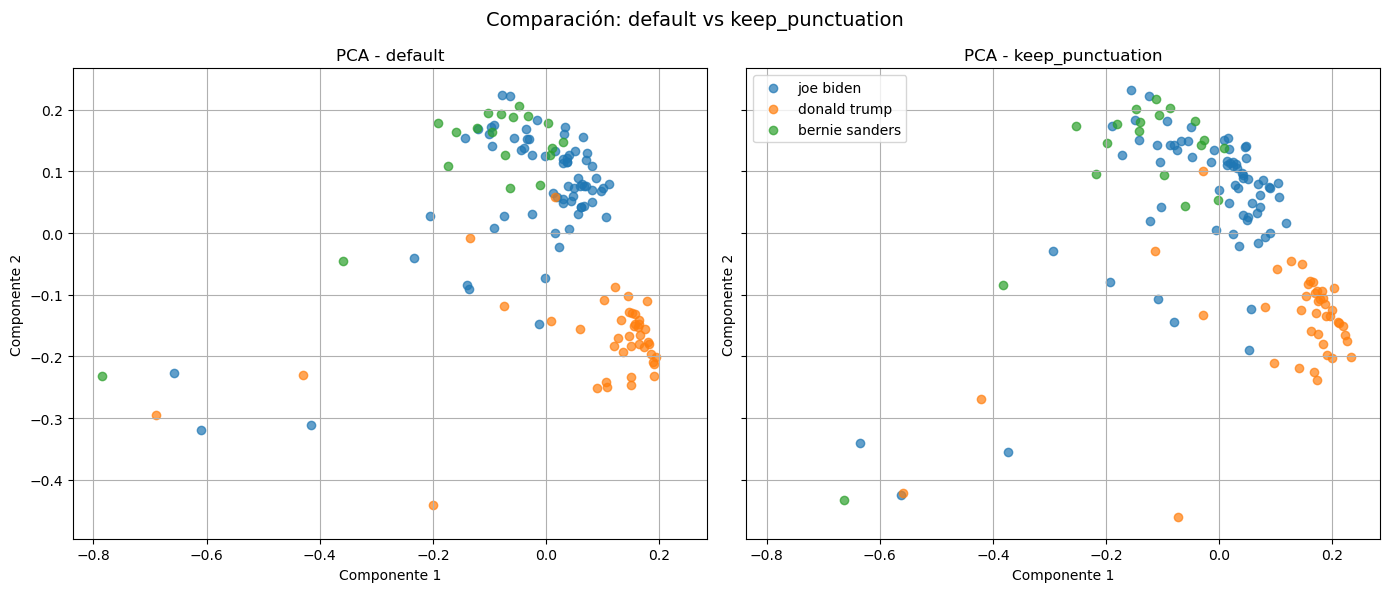

In [48]:
# Muestre en un mapa el conjunto de entrenamiento, utilizando las dos primeras componentes PCA sobre los vectores de tf-idf. Analice los resultados y 
# compare qué sucede si utiliza el filtrado de stop_words para idioma inglés, el parámetro use_idf=True y ngram_range=(1,2). 
# Opcionalmente, también puede analizar qué sucede si no elimina los signos de puntuación.

# Definimos la lista de comparaciones (pares)
pares = [
    ("default", {"stop_words": None, "ngram_range": (1, 1)}),
    ("stopwords_en", {"stop_words": "english", "ngram_range": (1, 1)}),
    ("ngram_1_2", {"stop_words": None, "ngram_range": (1, 2)}),
    ("stop_en_ngram_1_2", {"stop_words": "english", "ngram_range": (1, 2)}),
    ("keep_punctuation", {
        "stop_words": None,
        "ngram_range": (1, 1),
        "token_pattern": r"(?u)\b\w+\b|[^\w\s]"
    })
]

# Orden de etiquetas deseado para mantener colores consistentes por defecto
orden_etiquetas = ["joe biden", "donald trump", "bernie sanders"]

for nombre, params in pares[1:]:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    for i, (titulo, p) in enumerate([("default", pares[0][1]), (nombre, params)]):
        # Paso 1: Vectorización
        count_vectorizer = CountVectorizer(**p)
        X_counts = count_vectorizer.fit_transform(X_dev)

        # Paso 2: TF-IDF
        tfidf_transformer = TfidfTransformer()
        X_tfidf = tfidf_transformer.fit_transform(X_counts)

        # Paso 3: PCA
        X_dense = X_tfidf.toarray()
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_dense)

        # Paso 4: Gráfico con orden de etiquetas fijado
        ax = axes[i]
        for label in orden_etiquetas:
            idx = y_dev == label
            ax.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.7)
        ax.set_title(f"PCA - {titulo}")
        ax.set_xlabel("Componente 1")
        ax.set_ylabel("Componente 2")
        ax.grid(True)

    axes[1].legend()
    plt.suptitle(f"Comparación: default vs {nombre}", fontsize=14)
    plt.tight_layout()
    plt.show()

## Parte 2: Entrenamiento y Evaluación de Modelos


In [49]:
# 1: Entrene el modelo Multinomial Naive Bayes, luego utilícelo para predecir sobre el conjunto de test, y reporte el valor de accuracy y la matriz de confusión. 

In [50]:
# Definir el pipeline completo
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

# Entrenar el modelo sobre el conjunto de desarrollo
text_clf.fit(X_dev, y_dev)

# Predecir sobre el conjunto de test
y_pred = text_clf.predict(X_test)

# Calcular y mostrar las métricas
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")

Accuracy  : 0.5439
Precision : 0.2958
Recall    : 0.5439
F1-Score  : 0.3832


c:\Users\karin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
# Mostrar la matriz de confusión
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(conf_matrix)

Matriz de confusión:
[[ 0  0  8]
 [ 0  0 18]
 [ 0  0 31]]


In [52]:
# Reporte el valor de precision y recall para cada candidato. 
print(classification_report(y_test, y_pred, digits=3))

                precision    recall  f1-score   support

bernie sanders      0.000     0.000     0.000         8
  donald trump      0.000     0.000     0.000        18
     joe biden      0.544     1.000     0.705        31

      accuracy                          0.544        57
     macro avg      0.181     0.333     0.235        57
  weighted avg      0.296     0.544     0.383        57



c:\Users\karin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\karin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\karin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


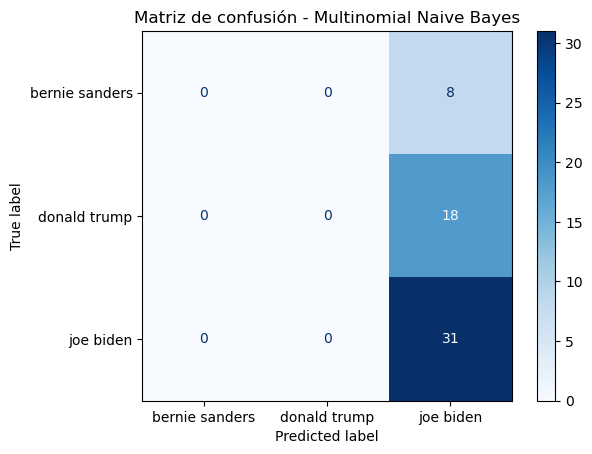

In [53]:
# Calcular matriz de confusión Sugerencia: utilice el método from_predictions de ConfusionMatrixDisplay para realizar la matriz.


# Mostrar matriz de confusión con etiquetas
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred, 
    display_labels=text_clf.classes_,  # Usa las etiquetas conocidas por el clasificador
    cmap='Blues',
    normalize=None  # También podés usar 'true' o 'pred' si querés normalizar
)

plt.title("Matriz de confusión - Multinomial Naive Bayes")
plt.show()

In [54]:
# 2: Implemente una búsqueda de hiperparámetros usando GridSearchCV.

In [ ]:
# Definimos la grilla de hiperparámetros a buscar
parameters = {
    # Como CountVectorizer tokeniza el texto:
    'vect__ngram_range': [(1, 1), (1, 2)],      # (1, 1): usa solo unigramas (palabras individuales). // (1, 2): usa unigramas y bigramas (secuencias de 2 palabras).  // Más bigramas : más contexto, pero también más dimensiones.
    'tfidf__use_idf': (True, False),            # True: aplica TF-IDF normal (penaliza palabras comunes en todo el corpus).  // False: solo usa TF (frecuencia dentro del documento), sin penalizar palabras comunes.
    # Parámetro de suavizado de Laplace en MultinomialNB.
    'clf__alpha': (1.0, 0.1, 0.01)              # alpha más bajo --> menos suavizado --> puede sobreajustar.  // alpha más alto --> más suavizado --> más general.
}

# Ejecutamos la búsqueda
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, scoring='f1_macro') # n_jobs=-1: usa todos los núcleos disponibles del procesador --> máxima paralelización
gs_clf = gs_clf.fit(X_dev, y_dev)

In [56]:
# Mejor combinación encontrada
print("Mejores hiperparámetros encontrados:")
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {gs_clf.best_params_[param_name]}")

# Accuracy con esos parámetros
print(f"\nMejor score (cross-validation): {gs_clf.best_score_:.4f}")


Mejores hiperparámetros encontrados:
clf__alpha: 0.01
tfidf__use_idf: True
vect__ngram_range: (1, 1)

Mejor score (cross-validation): 0.9139


C:\Users\karin\AppData\Local\Temp\ipykernel_26984\942698398.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_scores = scores_df.groupby('split_id')['f1_score'].mean().reindex(split_order)
c:\Users\karin\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


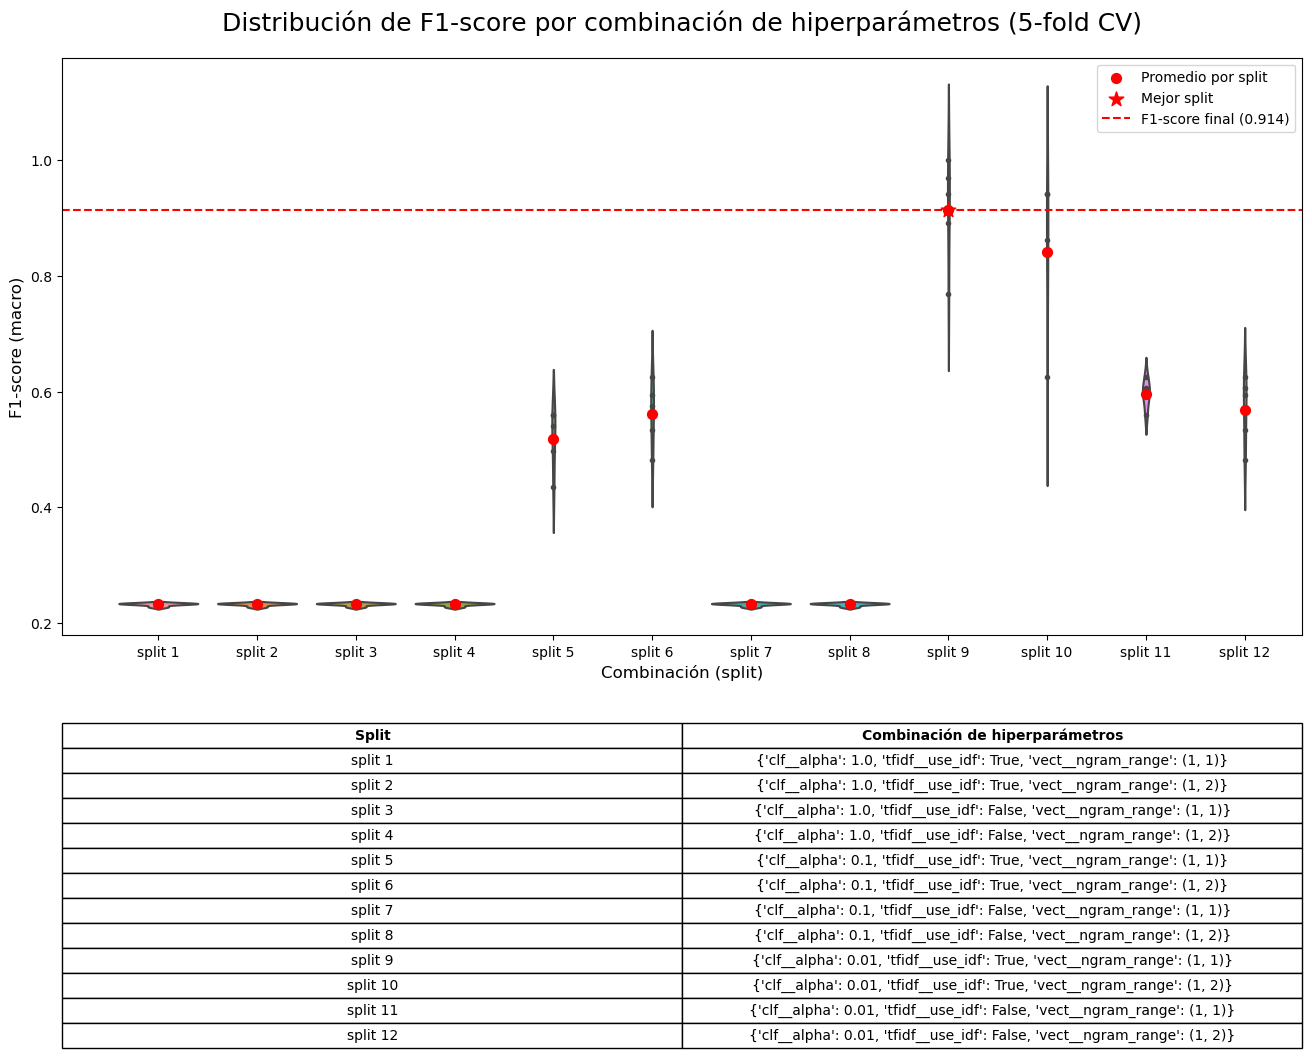

In [57]:
# Genere una visualización que permita comparar las métricas (e.g: accuracy) 
# de los distintos modelos entrenados, viendo el valor promedio y variabilidad de las mismas en todos los splits (e.g: en un gráfico de violín). 

# Accedemos a los resultados de GridSearchCV
cv_results = pd.DataFrame(gs_clf.cv_results_)

# Crear identificador corto tipo "split 1", "split 2", ...
cv_results['split_id'] = [f"split {i+1}" for i in range(len(cv_results))]
cv_results['params_str'] = cv_results['params'].apply(str)

# Expandimos los F1-scores de los 5 folds por combinación
rows = []
for idx, row in cv_results.iterrows():
    for i in range(5):  # para split0 a split4
        score = row[f'split{i}_test_score']
        split_id = row['split_id']
        rows.append({'split_id': split_id, 'f1_score': score})  

scores_df = pd.DataFrame(rows)

# Definir orden explícito para los splits
split_order = [f"split {i}" for i in range(1, 13)]
scores_df['split_id'] = pd.Categorical(scores_df['split_id'], categories=split_order, ordered=True)
cv_results['split_id'] = pd.Categorical(cv_results['split_id'], categories=split_order, ordered=True)

# Valor de F1-score final (mejor promedio)
final_f1 = gs_clf.best_score_
best_split = cv_results.loc[cv_results['mean_test_score'].idxmax(), 'split_id']
best_split_idx = split_order.index(best_split)

# Calcular el promedio de F1 por split
mean_scores = scores_df.groupby('split_id')['f1_score'].mean().reindex(split_order)

# Gráfico + tabla en subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [3, 1]})
fig.subplots_adjust(hspace=0.4)

# Violinplot de F1-score
sns.violinplot(data=scores_df, x='split_id', y='f1_score', inner='point', order=split_order, ax=ax1)

# Agregar puntos promedio
x_positions = np.arange(len(split_order))
y_means = mean_scores.values
ax1.scatter(x=x_positions, y=y_means, color='red', s=50, label='Promedio por split', zorder=5)

# Estrella en el mejor split
ax1.scatter(x=best_split_idx, y=mean_scores.iloc[best_split_idx],
            color='red', s=120, marker='*', label='Mejor split', zorder=6)

# Línea horizontal con el mejor F1-score
ax1.axhline(final_f1, color='red', linestyle='--', label=f'F1-score final ({final_f1:.3f})')

# Títulos
ax1.set_title("Distribución de F1-score por combinación de hiperparámetros (5-fold CV)", fontsize=18, pad=20)
ax1.set_xlabel("Combinación (split)", fontsize=12)
ax1.set_ylabel("F1-score (macro)", fontsize=12)
ax1.legend()

# Tabla visual
ax2.axis('off')
tabla_data = [[row['split_id'], row['params_str']] for _, row in cv_results.iterrows()]
tabla_plot = ax2.table(cellText=tabla_data,
                       colLabels=["Split", "Combinación de hiperparámetros"],
                       loc='center',
                       cellLoc='center',
                       colLoc='center')

tabla_plot.auto_set_font_size(False)
tabla_plot.set_fontsize(10)
tabla_plot.scale(1, 1.5)

for key, cell in tabla_plot.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

plt.show()


In [58]:
# Revisión de Desempeño por Combinación de Hiperparámetros (F1-Score en cada fold y promedio)
data = cv_results[['split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score','split_id', 'params_str']]

data

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,split_id,params_str
0,0.227642,0.233333,0.233333,0.233333,0.233333,0.232195,split 1,"{'clf__alpha': 1.0, 'tfidf__use_idf': True, 'v..."
1,0.227642,0.233333,0.233333,0.233333,0.233333,0.232195,split 2,"{'clf__alpha': 1.0, 'tfidf__use_idf': True, 'v..."
2,0.227642,0.233333,0.233333,0.233333,0.233333,0.232195,split 3,"{'clf__alpha': 1.0, 'tfidf__use_idf': False, '..."
3,0.227642,0.233333,0.233333,0.233333,0.233333,0.232195,split 4,"{'clf__alpha': 1.0, 'tfidf__use_idf': False, '..."
4,0.497354,0.541176,0.560224,0.560224,0.434070,0.518610,split 5,"{'clf__alpha': 0.1, 'tfidf__use_idf': True, 'v..."
5,0.533333,0.574495,0.593939,0.625000,0.481481,0.561650,split 6,"{'clf__alpha': 0.1, 'tfidf__use_idf': True, 'v..."
6,0.227642,0.233333,0.233333,0.233333,0.233333,0.232195,split 7,"{'clf__alpha': 0.1, 'tfidf__use_idf': False, '..."
7,0.227642,0.233333,0.233333,0.233333,0.233333,0.232195,split 8,"{'clf__alpha': 0.1, 'tfidf__use_idf': False, '..."
8,0.968898,0.891980,0.940887,1.000000,0.767742,0.913901,split 9,"{'clf__alpha': 0.01, 'tfidf__use_idf': True, '..."
9,0.837023,0.861814,0.940887,0.940887,0.625000,0.841122,split 10,"{'clf__alpha': 0.01, 'tfidf__use_idf': True, '..."


In [59]:
# 3: Elija el mejor modelo (mejores parámetros) y vuelva a entrenar sobre todo el conjunto de entrenamiento disponible (sin quitar datos para validación). 

best_params = gs_clf.best_params_

# Nuevo pipeline con los mejores hiperparámetros
final_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=best_params['vect__ngram_range'])),
    ('tfidf', TfidfTransformer(use_idf=best_params['tfidf__use_idf'])),
    ('clf', MultinomialNB(alpha=best_params['clf__alpha']))
])

# Entrenamos sobre TODO el conjunto de entrenamiento
final_clf.fit(X_dev, y_dev)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.01))])

Reporte de clasificación en test:
                precision    recall  f1-score   support

bernie sanders      1.000     0.750     0.857         8
  donald trump      1.000     1.000     1.000        18
     joe biden      0.939     1.000     0.969        31

      accuracy                          0.965        57
     macro avg      0.980     0.917     0.942        57
  weighted avg      0.967     0.965     0.963        57



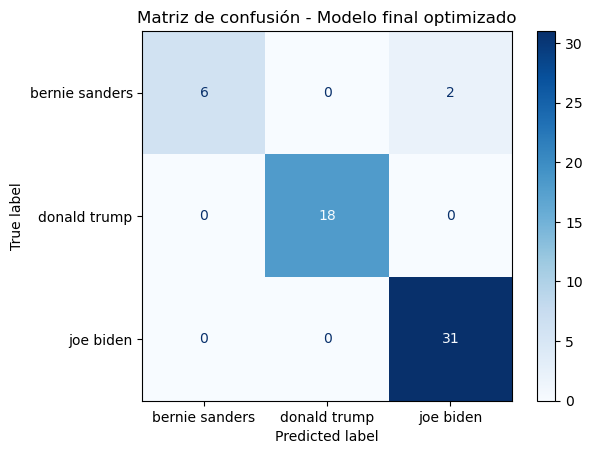

In [60]:
# Reporte el valor final de las métricas y la matriz de confusión.

# Predicción sobre test
y_pred_final = final_clf.predict(X_test)

# Reporte de métricas
print("Reporte de clasificación en test:")
print(classification_report(y_test, y_pred_final, digits=3))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final, cmap='Blues')
plt.title("Matriz de confusión - Modelo final optimizado")
plt.show()

In [61]:
acc = accuracy_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final, average='macro')  

print(f"Accuracy : {acc:.4f}")
print(f"F1-Score : {f1:.4f}")

Accuracy : 0.9649
F1-Score : 0.9420


In [62]:
# 4: Evalúe con validación cruzada al menos un modelo más (dentro de scikit-learn) aparte de Multinomial Naive Bayes para clasificar el texto utilizando las mismas features de texto.

# Definimos el pipeline con un clasificador SVM lineal
svm_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])

# Definimos la grilla de hiperparámetros a buscar
svm_params = {
    # Como CountVectorizer tokeniza el texto:
    'vect__ngram_range': [(1, 1), (1, 2)],     
    # (1, 1): usa solo unigramas (palabras individuales).
    # (1, 2): usa unigramas y bigramas (secuencias de 2 palabras).
    # Más bigramas → más contexto semántico, pero también más features.

    'tfidf__use_idf': [True, False],           
    # True: aplica TF-IDF clásico (penaliza palabras comunes en todo el corpus).
    # False: solo usa TF (frecuencia dentro del documento), sin penalización global.

    'clf__alpha': [1e-2, 1e-3, 1e-4],          
    # Controla la regularización del modelo (parecido a 1/C en SVM clásico).
    # Valores más bajos → menos regularización → posible sobreajuste.
    # Valores más altos → más regularización → generaliza más, menos sobreajuste.

    'clf__penalty': ['l2', 'l1'],              
    # Tipo de regularización:
    # 'l2': penaliza pesos grandes, tiende a mantener más features.
    # 'l1': induce dispersión (sparse), elimina features menos relevantes.

    'clf__loss': ['hinge', 'log_loss']         
    # Función de pérdida:
    # 'hinge' → SVM clásico.
    # 'log_loss' → regresión logística (también útil para clasificación binaria/multiclase).
}

# Ejecutamos la búsqueda con validación cruzada
gs_svm = GridSearchCV(svm_pipeline, svm_params, cv=5, n_jobs=-1, scoring='f1_macro')
gs_svm.fit(X_dev, y_dev)

# Mostramos los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
for param_name in sorted(svm_params.keys()):
    print(f"{param_name}: {gs_svm.best_params_[param_name]}")

print(f"\nMejor score (cross-validation): {gs_svm.best_score_:.4f}")

Mejores hiperparámetros encontrados:
clf__alpha: 0.001
clf__loss: hinge
clf__penalty: l1
tfidf__use_idf: True
vect__ngram_range: (1, 2)

Mejor score (cross-validation): 0.9742


In [63]:
# Entrenar el mejor modelo sobre todo el conjunto de desarrollo
best_svm = gs_svm.best_estimator_
best_svm.fit(X_dev, y_dev)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, penalty='l1', random_state=42))])

Accuracy en test (SVM optimizado): 0.9649
F1-Score en test (SVM optimizado): 0.9540

Reporte de clasificación (SVM optimizado):
                precision    recall  f1-score   support

bernie sanders      1.000     0.875     0.933         8
  donald trump      0.944     0.944     0.944        18
     joe biden      0.969     1.000     0.984        31

      accuracy                          0.965        57
     macro avg      0.971     0.940     0.954        57
  weighted avg      0.965     0.965     0.964        57



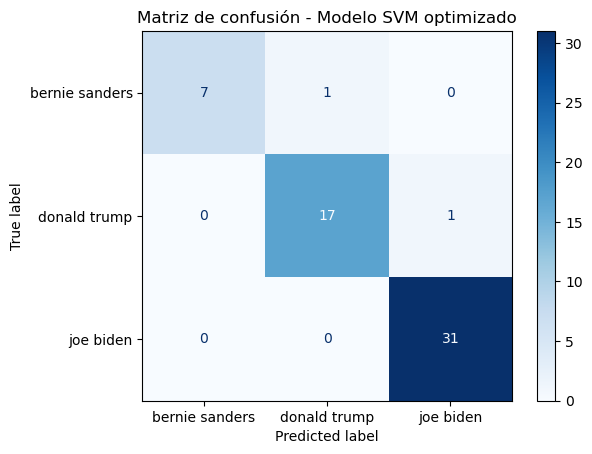

In [64]:
# Predicciones en test
y_pred_svm = best_svm.predict(X_test)

# Accuracy y F1-score
acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='macro')  

print(f"Accuracy en test (SVM optimizado): {acc_svm:.4f}")
print(f"F1-Score en test (SVM optimizado): {f1_svm:.4f}")

# Reporte de clasificación
print("\nReporte de clasificación (SVM optimizado):")
print(classification_report(y_test, y_pred_svm, digits=3))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap='Blues')
plt.title("Matriz de confusión - Modelo SVM optimizado")
plt.show()

In [65]:
# 5: Evalúe el problema cambiando al menos un candidato. En particular, observe el (des)balance de datos y los problemas que pueda generar, así como cualquier indicio que pueda ver en el mapeo previo con PCA.

### Preparación del Dataframe cambiando a Bernie Sanders por Mike Pence

In [66]:
# Paso 1: seleccionar columnas
df_reducido2 = df_speeches_sin_encabezados[['text1', 'joe biden', 'donald trump', 'mike pence']].copy()

# Paso 2: melt
df_melted2 = df_reducido2.melt(
    id_vars='text1',
    value_vars=['joe biden', 'donald trump', 'mike pence'],
    var_name='target',
    value_name='text_orador'
)

# Paso 3: eliminar vacíos/nulos
df_melted2 = df_melted2[df_melted2['text_orador'].notna() & (df_melted2['text_orador'].str.strip() != '')].reset_index(drop=True)

# Paso 4: aplicar limpieza
df_melted2['clean_text'] = clean_text(df_melted2, 'text_orador')

In [67]:
## Verificamos

# Función auxiliar: cuenta celdas con texto no vacío
def contar_textos_no_vacios(df, columnas):
    return sum((df[col].str.strip() != '').sum() for col in columnas)

# Columnas que nos interesan
columnas_oradores = ['joe biden', 'donald trump', 'mike pence']

# Conteo real de celdas con texto en el DataFrame original
conteo_original = contar_textos_no_vacios(df_speeches_sin_encabezados, columnas_oradores)

# Conteo de filas en el nuevo DataFrame ya "derretido"
conteo_melted2 = len(df_melted2)

print(f"Cantidad de celdas con texto en columnas originales: {conteo_original}")
print(f"Cantidad de filas en el nuevo DataFrame: {conteo_melted2}")

if conteo_original == conteo_melted2:
    print("✅ Coinciden: no se perdió información.")
else:
    print("⚠️ No coinciden: hay pérdida o exceso de datos.")

Cantidad de celdas con texto en columnas originales: 184
Cantidad de filas en el nuevo DataFrame: 184
✅ Coinciden: no se perdió información.


In [68]:
# Crear un Dataframe que solo contiene las columnas para Clasificación
df_clf2 = df_melted2[['clean_text', 'target']]

## Evaluación del problema cambiando a Bernie Sanders por Mike Pence

In [69]:
# 1: Separar 30% del conjunto para test. Al resto lo llamamos "dev" (desarrollo).

# Variables originales
X2 = df_clf2['clean_text']
y2 = df_clf2['target']

# División estratificada para mantener proporciones por clase
X2_dev, X2_test, y2_dev, y2_test = train_test_split(
    X2, y2, test_size=0.3, random_state=42, stratify=y2
)

# Mostrar tamaños de los conjuntos
print(f"Tamaños de los conjuntos: dev = {X2_dev.shape}, test = {X2_test.shape}")
print(f"Tamaños de los conjuntos: dev = {y2_dev.shape}, test = {y2_test.shape}")

Tamaños de los conjuntos: dev = (128,), test = (56,)
Tamaños de los conjuntos: dev = (128,), test = (56,)


In [70]:
# 2: Visualización de la proporción de cada candidato por conjunto

# Conteo de discursos por orador en cada conjunto
print("Distribución en el conjunto de desarrollo (dev):")
print(y2_dev.value_counts())

print("\nDistribución en el conjunto de test:")
print(y2_test.value_counts())

Distribución en el conjunto de desarrollo (dev):
target
joe biden       70
donald trump    42
mike pence      16
Name: count, dtype: int64

Distribución en el conjunto de test:
target
joe biden       31
donald trump    18
mike pence       7
Name: count, dtype: int64


In [71]:
# 3: Transforme el texto del conjunto de entrenamiento a la representación numérica (features) de conteo de palabras o bag of words.

# Crear el vectorizador y ajustarlo al conjunto de desarrollo
count_vect = CountVectorizer()

# Aplicar fit_transform para construir el vocabulario y transformar el texto
X2_dev_counts = count_vect.fit_transform(X2_dev)

# Mostrar forma de la matriz resultante
print("Shape de la matriz de conteo (Bag of Words):", X2_dev_counts.shape)

# 4: Obtenga la representación numérica Term Frequency - Inverse Document Frequency.

# Crear el transformador TF-IDF
tfidf2_transformer = TfidfTransformer()

# Ajustar al conjunto de desarrollo y transformar
X2_dev_tfidf = tfidf2_transformer.fit_transform(X2_dev_counts)

# Mostrar la shape de la matriz resultante
print("Shape de la matriz TF-IDF:", X2_dev_tfidf.shape)

Shape de la matriz de conteo (Bag of Words): (128, 12737)
Shape de la matriz TF-IDF: (128, 12737)


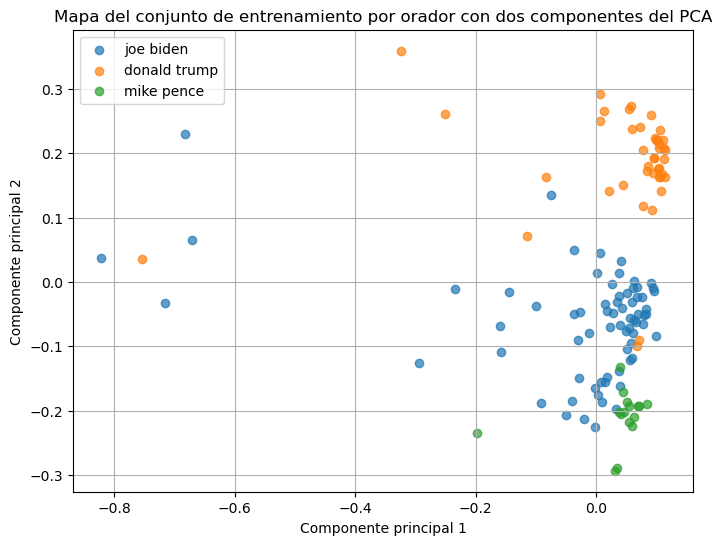

In [72]:
# 5 :Muestre en un mapa el conjunto de entrenamiento, utilizando las dos primeras componentes PCA sobre los vectores de tf-idf.

# Convertimos la matriz dispersa a array denso
X2_dense = X2_dev_tfidf.toarray()

# Aplicamos PCA para reducir a 2 dimensiones
pca2 = PCA(n_components=2)
X2_pca = pca2.fit_transform(X2_dense)

# Graficamos en 2D con colores por orador
plt.figure(figsize=(8, 6))

for label in y2_dev.unique():
    idx = y2_dev == label
    plt.scatter(X2_pca[idx, 0], X2_pca[idx, 1], label=label, alpha=0.7)

plt.title("Mapa del conjunto de entrenamiento por orador con dos componentes del PCA")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend()
plt.grid(True)
plt.show()

In [73]:
# 4: Evalúe con validación cruzada al menos un modelo más (dentro de scikit-learn) aparte de Multinomial Naive Bayes para clasificar el texto utilizando las mismas features de texto.

# Definimos el pipeline con un clasificador SVM lineal
svm_pipeline2 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])

# Definimos la grilla de hiperparámetros a buscar
svm_params2 = {
    # Como CountVectorizer tokeniza el texto:
    'vect__ngram_range': [(1, 1), (1, 2)],     
    # (1, 1): usa solo unigramas (palabras individuales).
    # (1, 2): usa unigramas y bigramas (secuencias de 2 palabras).
    # Más bigramas → más contexto semántico, pero también más features.

    'tfidf__use_idf': [True, False],           
    # True: aplica TF-IDF clásico (penaliza palabras comunes en todo el corpus).
    # False: solo usa TF (frecuencia dentro del documento), sin penalización global.

    'clf__alpha': [1e-2, 1e-3, 1e-4],          
    # Controla la regularización del modelo (parecido a 1/C en SVM clásico).
    # Valores más bajos → menos regularización → posible sobreajuste.
    # Valores más altos → más regularización → generaliza más, menos sobreajuste.

    'clf__penalty': ['l2', 'l1'],              
    # Tipo de regularización:
    # 'l2': penaliza pesos grandes, tiende a mantener más features.
    # 'l1': induce dispersión (sparse), elimina features menos relevantes.

    'clf__loss': ['hinge', 'log_loss']         
    # Función de pérdida:
    # 'hinge' → SVM clásico.
    # 'log_loss' → regresión logística (también útil para clasificación binaria/multiclase).
}

# Ejecutamos la búsqueda con validación cruzada
gs_svm2 = GridSearchCV(svm_pipeline2, svm_params2, cv=5, n_jobs=-1, scoring='f1_macro')
gs_svm2.fit(X2_dev, y2_dev)

# Mostramos los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
for param_name in sorted(svm_params2.keys()):
    print(f"{param_name}: {gs_svm2.best_params_[param_name]}")

print(f"\nMejor score (cross-validation): {gs_svm2.best_score_:.4f}")

Mejores hiperparámetros encontrados:
clf__alpha: 0.0001
clf__loss: log_loss
clf__penalty: l2
tfidf__use_idf: False
vect__ngram_range: (1, 1)

Mejor score (cross-validation): 0.9940


In [74]:
# Entrenar el mejor modelo sobre todo el conjunto de desarrollo
best_svm2 = gs_svm2.best_estimator_
best_svm2.fit(X2_dev, y2_dev)

Pipeline(steps=[('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', SGDClassifier(loss='log_loss', random_state=42))])

Accuracy en test (SVM optimizado): 0.9107
F1-Score en test (SVM optimizado): 0.8778

Reporte de clasificación (SVM optimizado):
              precision    recall  f1-score   support

donald trump      1.000     0.889     0.941        18
   joe biden      0.882     0.968     0.923        31
  mike pence      0.833     0.714     0.769         7

    accuracy                          0.911        56
   macro avg      0.905     0.857     0.878        56
weighted avg      0.914     0.911     0.910        56



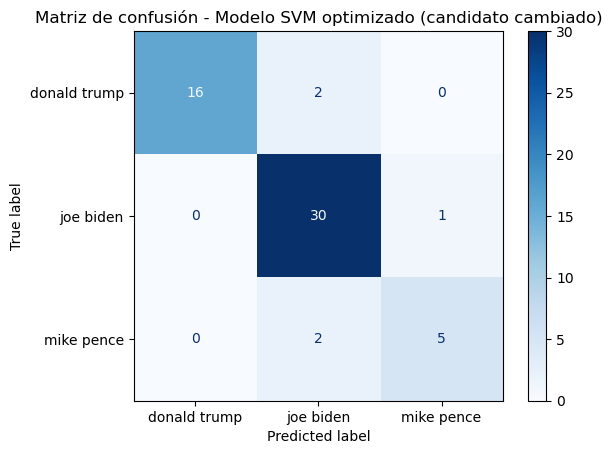

In [75]:
# Predicciones en test para la segunda variante (cambiando un candidato)
y2_pred_svm = best_svm2.predict(X2_test)

# Accuracy y F1-score macro
acc_svm2 = accuracy_score(y2_test, y2_pred_svm)
f1_svm2 = f1_score(y2_test, y2_pred_svm, average='macro')

print(f"Accuracy en test (SVM optimizado): {acc_svm2:.4f}")
print(f"F1-Score en test (SVM optimizado): {f1_svm2:.4f}")

# Reporte de clasificación detallado
print("\nReporte de clasificación (SVM optimizado):")
print(classification_report(y2_test, y2_pred_svm, digits=3))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y2_test, y2_pred_svm, cmap='Blues')
plt.title("Matriz de confusión - Modelo SVM optimizado (candidato cambiado)")
plt.show()

In [76]:
# Convertimos los resultados a DataFrame
cv_results_df2 = pd.DataFrame(gs_svm2.cv_results_)

data2 = cv_results_df2[[
    'split0_test_score', 'split1_test_score', 'split2_test_score',
    'split3_test_score', 'split4_test_score', 'mean_test_score', 'params'
]]

# Mostramos
#data2

In [77]:
# OPCIONAL: Repetir la clasificación con los tres candidatos con más discursos, pero esta vez clasificando a nivel de párrafos y no de discursos enteros.